In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import pandas as pd

from lightgbm import LGBMClassifier
import shap
from sklearn.inspection import permutation_importance

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
cred = pd.read_parquet('../data/credit_history.parquet', engine="fastparquet")
xml = pd.read_xml('../data/geographic_data.xml')
xlsx = pd.read_excel('../data/loan_details.xlsx')
jsonl = pd.read_json('../data/financial_ratios.jsonl', lines=True)
demog = pd.read_csv('../data/demographics.csv')
appl = pd.read_csv('../data/application_metadata.csv')

In [33]:
dfs = [cred, xml, xlsx, jsonl, demog, appl]
key_names = ["customer_number", "id", "customer_id", "cust_num", "cust_id", "customer_ref"]

for i in range(len(dfs)):
    dfs[i] = dfs[i].rename(columns={key_names[i]: "customer_id"})

In [34]:
from functools import reduce

merged = reduce(
    lambda left, right: left.merge(right, on="customer_id", how="inner"),
    dfs
)

In [36]:
merged.to_csv('../data/merged_data.csv', index=False)

In [3]:
df = pd.read_csv('../data/merged_data.csv')

In [4]:
pd.set_option("display.max_columns", None)

# loan_officer_id, 

In [5]:
df['employment_type'].replace({'Full Time': 'Full-time', 'FULL_TIME': 'Full-time', 'Fulltime': 'Full-time', 'FT': 'Full-time',
                                   'SELF_EMPLOYED': 'Self-employed', 'Self Emp': 'Self-employed', 'Self Employed': 'Self-employed',
                                   'PART_TIME': 'Part-time', 'PT': 'Part-time', 'Part Time': 'Part-time',
                                   'Contractor': 'Contract', 'CONTRACT': 'Contract'}, inplace=True)

df['loan_type'].replace({'Personal Loan': 'Personal', 'personal': 'Personal', 'PERSONAL': 'Personal',
                             'MORTGAGE': 'Mortgage', 'mortgage': 'Mortgage',
                             'CreditCard': 'C|redit Card', 'credit card': 'Credit Card', 'CC': 'Credit Card'}, inplace=True)

In [6]:
columns_to_fix = ['loan_amount', 'monthly_income', 'existing_monthly_debt', 'monthly_payment', 
                    'revolving_balance', 'credit_usage_amount', 'available_credit', 'total_debt_amount',
                    'monthly_free_cash_flow', 'annual_income', 'total_monthly_debt_payment']

for col in columns_to_fix:
    # Remove $ sign and commas, then convert to float
    df[col] = df[col].astype(str).str.replace(r"[$,]", "", regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [7]:
df.drop(columns=['customer_id', 'application_id', 'random_noise_1', 'recent_inquiry_count',
                    'oldest_credit_line_age', 'loan_officer_id', 'previous_zip_code', 
                    'marketing_campaign', 'referral_code', 'account_status_code', 'state'], inplace=True)

In [8]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

Features with MI >= 0.99: ['monthly_free_cash_flow', 'loan_to_annual_income', 'credit_score', 'employment_type_Full-time', 'paperless_billing', 'annual_income', 'has_mobile_app', 'monthly_income', 'debt_to_income_ratio', 'marital_status_Married', 'debt_service_ratio', 'age', 'payment_to_income_ratio', 'available_credit', 'origination_channel_Online', 'oldest_account_age_months', 'total_credit_limit']


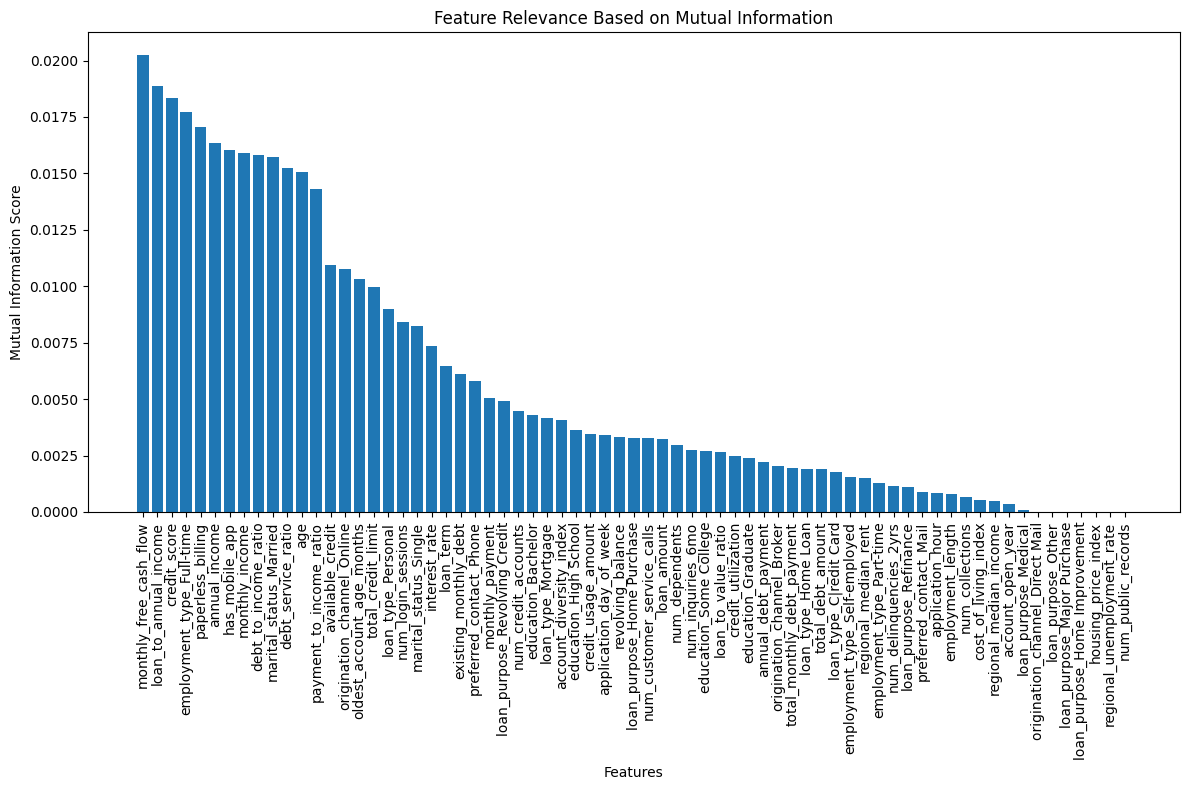

In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# ---- 1. Prepare numeric data ----
df_t = df.select_dtypes('number').copy()
fill_cols = ['num_delinquencies_2yrs', 'revolving_balance', 'employment_length']
df_t[fill_cols] = df_t[fill_cols].fillna(0.0)

X = df_t.drop("default", axis=1)
y = df_t["default"]

# ---- 2. Calculate Mutual Information scores ----
mi_scores = mutual_info_classif(X, y, random_state=42)

# ---- 3. Put into DataFrame ----
mi_df = pd.DataFrame({
    "feature": X.columns,
    "mi_score": mi_scores
}).sort_values(by="mi_score", ascending=False)

# ---- 4. Filter features with MI >= 0.99 ----
high_mi_features = mi_df[mi_df["mi_score"] >= 0.0099]["feature"].tolist()
print("Features with MI >= 0.99:", high_mi_features)

# ---- 5. Optional: Plot MI scores ----
plt.figure(figsize=(12, 8))
plt.bar(mi_df["feature"], mi_df["mi_score"])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.title("Feature Relevance Based on Mutual Information")
plt.tight_layout()
plt.show()

In [110]:
high_mi_features

['monthly_free_cash_flow',
 'credit_score',
 'loan_to_annual_income',
 'has_mobile_app',
 'annual_income',
 'monthly_income',
 'paperless_billing',
 'marital_status_Married',
 'payment_to_income_ratio',
 'debt_service_ratio',
 'employment_type_Full-time',
 'debt_to_income_ratio',
 'age',
 'available_credit',
 'origination_channel_Online',
 'oldest_account_age_months']

,monthly_free_cash_flow,credit_score,loan_to_annual_income,has_mobile_app,annual_income,monthly_income,paperless_billing,marital_status_Married,payment_to_income_ratio,debt_service_ratio,employment_type_Full-time,debt_to_income_ratio,age,available_credit,origination_channel_Online,oldest_account_age_months
0,3819.230000,696,0.286408,1,61800,5150.00,1,1,0.115,0.258402,1,0.258,41,26886.9,0,273.6
1,977.260000,659,3.986014,1,28600,2383.33,1,1,0.425,0.589959,1,0.590,38,2267.8,0,42.0
2,1203.120000,662,0.449275,1,20700,1725.00,0,0,0.184,0.302539,1,0.303,18,19085.4,1,0.0
3,2093.436667,676,0.277070,1,31400,2616.67,1,0,0.090,0.199961,1,0.200,27,51180.0,1,108.0
4,1466.420000,678,0.292683,1,24600,2050.00,0,0,0.163,0.284673,1,0.285,26,25446.4,0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89994,3384.160000,817,0.156293,0,72300,6025.00,1,0,0.086,0.438314,1,0.438,52,86919.6,0,98.4
89995,982.260000,745,0.825000,1,20000,1666.67,0,0,0.327,0.410646,1,0.411,61,28767.0,0,105.6
89996,919.806667,607,0.890000,1,20000,1666.67,1,1,0.370,0.448116,1,0.448,19,6057.3,1,12.0
89997,1153.560000,678,0.585000,0,20000,1666.67,0,1,0.211,0.307866,1,0.308,21,23783.4,0,36.0


In [12]:
# Keep only raw feature names that exist in X.columns


X_sel = df[high_mi_features]

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_sel, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [41]:
# preprocess_sel = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), high_mi_features)
#     ]
# )

# final_model = Pipeline(steps=[
#     #("preprocess", preprocess_sel),
#     ("model", LGBMClassifier(
#         n_estimators=1200,
#         learning_rate=0.03,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         max_depth=-1,
#         random_state=42
#     ))
# ])

smote_lgbm = Pipeline(steps=[
    ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
    ('model', LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=-1,
        random_state=42
    ))
])

smote_lgbm.fit(X_train_s, y_train_s)
preds_final = smote_lgbm.predict_proba(X_test_s)[:, 1]

print("Final Model AUC:", roc_auc_score(y_test_s, preds_final))

[LightGBM] [Info] Number of positive: 6832, number of negative: 68324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2857
[LightGBM] [Info] Number of data points in the train set: 75156, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090904 -> initscore=-2.302644
[LightGBM] [Info] Start training from score -2.302644
Final Model AUC: 0.778535530541001


In [39]:
from xgboost import XGBClassifier


smote_xgb = Pipeline(steps=[
    ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
    ('model', XGBClassifier(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    ))
])


xgb_model = Pipeline(steps=[
    ("model", XGBClassifier(
        n_estimators=1200,
        learning_rate=0.03,
        max_depth=6,       # XGBoost doesn't allow -1; use a high number instead
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

smote_xgb.fit(X_train_s, y_train_s)
preds_xgb = smote_xgb.predict_proba(X_test_s)[:, 1]
print("XGBoost AUC:", roc_auc_score(y_test_s, preds_xgb))


XGBoost AUC: 0.7776330903404051


In [40]:
from catboost import CatBoostClassifier

# cat_model = Pipeline(steps=[
#     ("model", CatBoostClassifier(
#         iterations=1200,
#         learning_rate=0.03,
#         depth=6,
#         subsample=0.8,
#         colsample_bylevel=0.8,
#         random_seed=42,
#         verbose=0,
#         allow_writing_files=False  # <-- disables the folder
#     ))
# ])

smote_cat = Pipeline(steps=[
    ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
    ('model', CatBoostClassifier(
        iterations=1200,
        learning_rate=0.03,
        depth=6,
        random_seed=42,
        verbose=0,
        train_dir=None
    ))
])

smote_cat.fit(X_train_s, y_train_s)
preds_cat = smote_cat.predict_proba(X_test_s)[:, 1]
print("CatBoost AUC:", roc_auc_score(y_test_s, preds_cat))


CatBoost AUC: 0.7814028772464094


In [19]:
cat_preds = cat_model.predict(X_test_s)

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_score(y_test_s, cat_preds)

0.9494444444444444

In [21]:
confusion_matrix(y_test_s, cat_preds)

array([[17042,    39],
       [  871,    48]])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# rf_model = Pipeline(steps=[
#     ("model", RandomForestClassifier(
#         n_estimators=1200,
#         max_depth=None,     # None = unlimited depth
#         max_features='sqrt',
#         bootstrap=True,
#         random_state=42,
#         n_jobs=-1
#     ))
# ])

smote_rf = Pipeline(steps=[
    ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
    ('model', RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        class_weight=None,  # you can also try 'balanced'
        random_state=42
    ))
])


smote_rf.fit(X_train_s, y_train_s)
preds_rf = smote_rf.predict_proba(X_test_s)[:, 1]
print("Random Forest AUC:", roc_auc_score(y_test_s, preds_rf))


In [114]:
clean_features = [
    'credit_score', 'num_credit_accounts',
    'oldest_account_age_months', 'total_credit_limit',
    'num_delinquencies_2yrs', 'num_inquiries_6mo',
    'num_public_records', 'num_collections',
    'account_diversity_index', 'state',
    'regional_unemployment_rate', 'regional_median_income',
    'regional_median_rent', 'housing_price_index',
    'cost_of_living_index', 'loan_type', 'loan_amount',
    'loan_term', 'interest_rate', 'loan_purpose',
    'loan_to_value_ratio', 'origination_channel',
    'monthly_income', 'existing_monthly_debt',
    'monthly_payment', 'debt_to_income_ratio',
    'debt_service_ratio', 'payment_to_income_ratio',
    'credit_utilization', 'revolving_balance',
    'credit_usage_amount', 'available_credit',
    'total_monthly_debt_payment', 'annual_debt_payment',
    'loan_to_annual_income', 'total_debt_amount',
    'monthly_free_cash_flow', 'age', 'annual_income',
    'employment_length', 'employment_type', 'education',
    'marital_status', 'num_dependents',
    'application_hour', 'application_day_of_week',
    'account_open_year', 'preferred_contact',
    'num_login_sessions', 'num_customer_service_calls',
    'has_mobile_app', 'paperless_billing', 'default'
]

In [129]:
df_model = df[clean_features].copy()

X = df_model.drop(columns=['default'])
y = df_model['default']

In [130]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [131]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [132]:
model = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [134]:
pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]

print("Baseline AUC:", roc_auc_score(y_test, preds))

[LightGBM] [Info] Number of positive: 3675, number of negative: 68324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6779
[LightGBM] [Info] Number of data points in the train set: 71999, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.051042 -> initscore=-2.922708
[LightGBM] [Info] Start training from score -2.922708
Baseline AUC: 0.8057330243487489


In [135]:
# Extract trained LightGBM booster
trained_model = pipeline.named_steps["model"]

# Prepare data after preprocessing
X_train_transformed = pipeline.named_steps["preprocess"].transform(X_train)

explainer = shap.TreeExplainer(trained_model)
shap_values = explainer.shap_values(X_train_transformed)

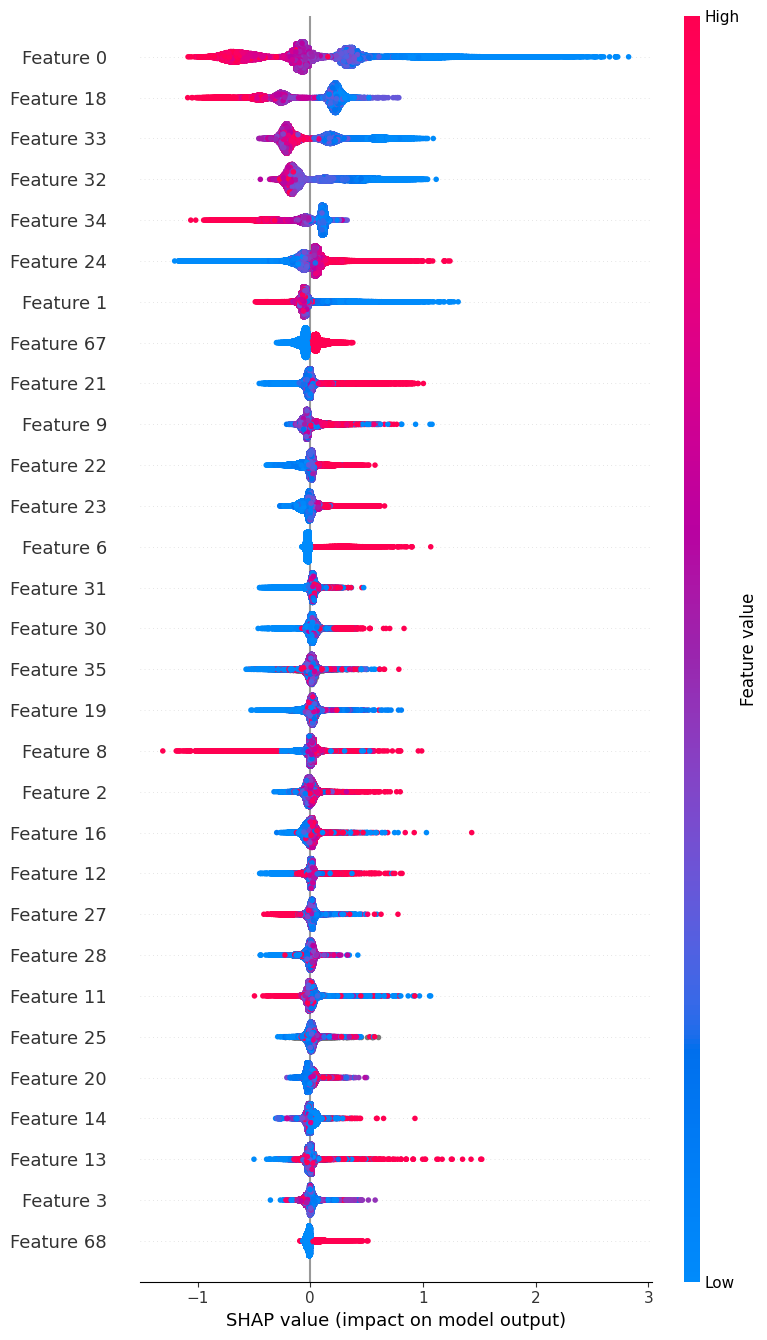

In [136]:
shap.summary_plot(shap_values, X_train_transformed, max_display=30)

In [137]:
shap_importance = np.mean(np.abs(shap_values), axis=0)

feature_names = pipeline.named_steps["preprocess"].get_feature_names_out()
shap_df = pd.DataFrame({
    "feature": feature_names,
    "shap_importance": shap_importance
}).sort_values(by="shap_importance", ascending=False)

In [140]:
perm = permutation_importance(
    pipeline, X_test, y_test, n_repeats=5, scoring="roc_auc", random_state=42
)

perm_df = pd.DataFrame({
    "feature": X.columns,
    "importance": perm.importances_mean
}).sort_values(by="importance", ascending=False)

In [142]:
feature_names

array(['num__credit_score', 'num__num_credit_accounts',
       'num__oldest_account_age_months', 'num__total_credit_limit',
       'num__num_delinquencies_2yrs', 'num__num_inquiries_6mo',
       'num__num_public_records', 'num__num_collections',
       'num__account_diversity_index', 'num__regional_unemployment_rate',
       'num__regional_median_income', 'num__regional_median_rent',
       'num__housing_price_index', 'num__cost_of_living_index',
       'num__loan_amount', 'num__loan_term', 'num__interest_rate',
       'num__loan_to_value_ratio', 'num__monthly_income',
       'num__existing_monthly_debt', 'num__monthly_payment',
       'num__debt_to_income_ratio', 'num__debt_service_ratio',
       'num__payment_to_income_ratio', 'num__credit_utilization',
       'num__revolving_balance', 'num__credit_usage_amount',
       'num__available_credit', 'num__total_monthly_debt_payment',
       'num__annual_debt_payment', 'num__loan_to_annual_income',
       'num__total_debt_amount', 'num__mo

In [165]:
top_shap = shap_df.head(25)['feature']
top_perm = perm_df.head(25)['feature']

selected_features = list(set(top_shap) | set(top_perm))

In [150]:
X_selected = X[selected_features]

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

pipeline_final = Pipeline(steps=[
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), [f for f in selected_features if f in num_features]),
            ("cat", OneHotEncoder(handle_unknown="ignore"), [f for f in selected_features if f in cat_features])
        ]
    )),
    ("model", LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

pipeline_final.fit(X_train_s, y_train_s)
preds_final = pipeline_final.predict_proba(X_test_s)[:, 1]

print("Final Model AUC:", roc_auc_score(y_test_s, preds_final))

KeyError: "None of [Index(['num__debt_to_income_ratio', 'num__annual_income',\n       'num__payment_to_income_ratio', 'num__regional_unemployment_rate',\n       'num__existing_monthly_debt', 'num__credit_utilization', 'num__age',\n       'num__available_credit', 'num__total_debt_amount', 'num__interest_rate',\n       'cat__loan_type_Personal', 'num__regional_median_rent',\n       'num__oldest_account_age_months', 'num__housing_price_index',\n       'num__monthly_income', 'num__debt_service_ratio',\n       'num__total_monthly_debt_payment', 'num__revolving_balance',\n       'num__employment_length', 'num__account_diversity_index',\n       'num__credit_score', 'num__num_public_records',\n       'num__monthly_free_cash_flow', 'num__num_credit_accounts',\n       'num__loan_to_annual_income'],\n      dtype='object')] are in the [columns]"

In [148]:
top_perm

0                   credit_score
37                           age
36        monthly_free_cash_flow
22                monthly_income
1            num_credit_accounts
38                 annual_income
25          debt_to_income_ratio
15                     loan_type
26            debt_service_ratio
28            credit_utilization
10    regional_unemployment_rate
34         loan_to_annual_income
19                  loan_purpose
3             total_credit_limit
6             num_public_records
35             total_debt_amount
18                 interest_rate
24               monthly_payment
48            num_login_sessions
27       payment_to_income_ratio
13           housing_price_index
29             revolving_balance
45       application_day_of_week
8        account_diversity_index
12          regional_median_rent
Name: feature, dtype: object

In [166]:
selected_features

['num__debt_to_income_ratio',
 'credit_score',
 'num_login_sessions',
 'application_day_of_week',
 'num__annual_income',
 'account_diversity_index',
 'num__payment_to_income_ratio',
 'num__regional_unemployment_rate',
 'num__existing_monthly_debt',
 'num__credit_utilization',
 'credit_utilization',
 'monthly_free_cash_flow',
 'num__age',
 'monthly_payment',
 'num__available_credit',
 'num__total_debt_amount',
 'num__interest_rate',
 'debt_to_income_ratio',
 'cat__loan_type_Personal',
 'monthly_income',
 'regional_median_rent',
 'num__regional_median_rent',
 'num__oldest_account_age_months',
 'loan_purpose',
 'loan_type',
 'num__housing_price_index',
 'num__monthly_income',
 'housing_price_index',
 'num__debt_service_ratio',
 'total_debt_amount',
 'payment_to_income_ratio',
 'num__total_monthly_debt_payment',
 'num__revolving_balance',
 'age',
 'num__employment_length',
 'revolving_balance',
 'num__account_diversity_index',
 'loan_to_annual_income',
 'regional_unemployment_rate',
 'num_

In [167]:
# Extract trained model
model = pipeline.named_steps["model"]
preprocess = pipeline.named_steps["preprocess"]

# Transform training data
X_train_transformed = preprocess.transform(X_train)

# SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)

# SHAP importance per encoded feature
shap_importance = np.mean(np.abs(shap_values), axis=0)

encoded_feature_names = preprocess.get_feature_names_out()

shap_df = pd.DataFrame({
    "feature": encoded_feature_names,
    "importance": shap_importance
}).sort_values(by="importance", ascending=False)

In [168]:
def aggregate_shap_importance(shap_df):
    agg = {}

    for f, imp in zip(shap_df['feature'], shap_df['importance']):
        # Extract base feature name before OHE expansion
        base = f.split("__")[1] if "__" in f else f
        agg[base] = agg.get(base, 0) + imp

    return pd.DataFrame({
        "feature": list(agg.keys()),
        "shap_importance": list(agg.values())
    }).sort_values(by="shap_importance", ascending=False)

shap_agg_df = aggregate_shap_importance(shap_df)

top_shap_features = shap_agg_df.head(25)['feature'].tolist()

In [169]:
perm = permutation_importance(
    pipeline, X_test, y_test,
    n_repeats=5,
    scoring="roc_auc",
    random_state=42
)

perm_df = pd.DataFrame({
    "feature": X.columns,
    "importance": perm.importances_mean
}).sort_values(by="importance", ascending=False)

top_perm_features = perm_df.head(25)['feature'].tolist()

selected_features = sorted(list(set(top_shap_features + top_perm_features)))
len(selected_features), selected_features

(31,
 ['account_diversity_index',
  'age',
  'annual_income',
  'application_day_of_week',
  'available_credit',
  'credit_score',
  'credit_utilization',
  'debt_service_ratio',
  'debt_to_income_ratio',
  'employment_length',
  'existing_monthly_debt',
  'housing_price_index',
  'interest_rate',
  'loan_purpose',
  'loan_to_annual_income',
  'loan_type',
  'loan_type_Personal',
  'monthly_free_cash_flow',
  'monthly_income',
  'monthly_payment',
  'num_credit_accounts',
  'num_login_sessions',
  'num_public_records',
  'oldest_account_age_months',
  'payment_to_income_ratio',
  'regional_median_rent',
  'regional_unemployment_rate',
  'revolving_balance',
  'total_credit_limit',
  'total_debt_amount',
  'total_monthly_debt_payment'])

In [170]:
domain_critical = [
    'credit_score', 'debt_to_income_ratio',
    'num_delinquencies_2yrs', 'credit_utilization',
    'payment_to_income_ratio', 'employment_length'
]

for f in domain_critical:
    if f in X.columns and f not in selected_features:
        selected_features.append(f)

In [173]:
# Keep only raw feature names that exist in X.columns
selected_features = [f for f in selected_features if f in X.columns]

missing = [f for f in selected_features if f not in X.columns]
print("Missing (encoded) features removed:", missing)

X_sel = X[selected_features]

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_sel, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

preprocess_sel = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), [f for f in selected_features if f in num_features]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), [f for f in selected_features if f in cat_features])
    ]
)

final_model = Pipeline(steps=[
    ("preprocess", preprocess_sel),
    ("model", LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=-1,
        random_state=42
    ))
])

final_model.fit(X_train_s, y_train_s)
preds_final = final_model.predict_proba(X_test_s)[:, 1]

print("Final Model AUC:", roc_auc_score(y_test_s, preds_final))

Missing (encoded) features removed: []
[LightGBM] [Info] Number of positive: 3675, number of negative: 68324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5488
[LightGBM] [Info] Number of data points in the train set: 71999, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.051042 -> initscore=-2.922708
[LightGBM] [Info] Start training from score -2.922708
Final Model AUC: 0.8000457272042911


In [ ]:
model2 = final_model.named_steps["model"]
preproc2 = final_model.named_steps["preprocess"]

X_train_s_transformed = preproc2.transform(X_train_s)

expl2 = shap.TreeExplainer(model2)
shap_vals2 = expl2.shap_values(X_train_s_transformed)

shap.summary_plot(shap_vals2, X_train_s_transformed, feature_names=preproc2.get_feature_names_out())

In [171]:
cat_features

['state',
 'loan_type',
 'loan_purpose',
 'origination_channel',
 'employment_type',
 'education',
 'marital_status',
 'preferred_contact']

In [163]:
X[selected_features]

KeyError: "['loan_type_Personal'] not in index"

['account_diversity_index',
 'age',
 'annual_income',
 'credit_score',
 'credit_utilization',
 'debt_service_ratio',
 'debt_to_income_ratio',
 'employment_length',
 'existing_monthly_debt',
 'interest_rate',
 'loan_purpose',
 'loan_to_annual_income',
 'loan_type',
 'loan_type_Personal',
 'monthly_free_cash_flow',
 'monthly_income',
 'monthly_payment',
 'num_credit_accounts',
 'num_login_sessions',
 'num_public_records',
 'oldest_account_age_months',
 'payment_to_income_ratio',
 'regional_unemployment_rate',
 'total_credit_limit',
 'total_debt_amount',
 'num_delinquencies_2yrs']